In [53]:
import numpy as np
from numpy.testing import assert_allclose
from time import perf_counter

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')  # make plots a bit nicer by default

# custom imports
from plot_utils import plot_matrix_evolution


# Set global constant NOTEBOOK_START_TIME. This block is idempotent.
if 'NOTEBOOK_START_TIME' in globals():
    print(f"Notebook start time: {NOTEBOOK_START_TIME:.2f}, which was {perf_counter() - NOTEBOOK_START_TIME:.2f} seconds ago.")  # type: ignore
else:
    NOTEBOOK_START_TIME = perf_counter()
    print(f"Notebook start time newly set to: {NOTEBOOK_START_TIME}")

Notebook start time: 604496.74, which was 3355.38 seconds ago.


## To do / Questions

1. Finish rewriting old code
    * $Q$, multi-$w$
    * $UU^\top$, training loop
    * $UU^\top$, single $w$
    * $UU^\top$, multi-$w$

2. Check that each of the above is learning properly
    * Performs better than one step of GD
        * on new data with the same $w_\star$
        * on new data with a different $w_\star$??
    * How consistent are learned matrices over multiple runs w/ same init?
        * if not consistent, what properties do they share?

3. What patterns are visible in learned $Q$?
    * Eigenvalues, vectors.
    * Low-rank $\Sigma_w$: do you capture this subspace?
    * Patterns in imshow

4. Update potential based on whole batch rather than a single datapoint, for easier interp?

5. Optimization-style objective, rather than crossval

# Generating data

In [54]:
def generate_linear_data(d_feature: int, n_samples: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e where X is (n_samples, d_feature) and w is (d_feature, 1).

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    w = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov)
    X = np.random.randn(n_samples, d_feature)
    y = X @ w + np.random.normal(scale=noise_scale, size=(n_samples,))
    
    return X, y.ravel(), w


def generate_mixed_linear_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w.
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.random.randn(n_ws * n_samples_per_w, d_feature)
    y = np.concatenate([X[i * n_samples_per_w : (i+1) * n_samples_per_w] @ W[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W


def generate_specified_linear_data(n_samples_per_w: int, w_stars: np.ndarray, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for specified w vectors.

    Args:
        n_samples_per_w: Number of samples to generate for each w.
        w_stars: Array of weight vectors, shape (n_ws, d_feature).
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    n_ws, d_feature = w_stars.shape
    X = np.random.randn(n_ws * n_samples_per_w, d_feature)
    y = np.concatenate([X[i*n_samples_per_w:(i+1)*n_samples_per_w] @ w_stars[i] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, w_stars


def generate_std_basis_data(d_feature: int, n_samples: int, w: np.ndarray = None) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples: Number of samples to generate (must be <= d_feature).
        w: True weight vector. If None, randomly generated.

    Returns:
        X: Feature matrix of shape (n_samples, d_feature).
        y: Target vector of shape (n_samples,).
        w: True weight vector of shape (d_feature,).
    """
    assert n_samples <= d_feature, "n_samples must be <= d_feature for standard basis vectors"
    
    if w is None:
        w = np.random.randn(d_feature)
    
    X = np.eye(d_feature)[:n_samples]
    y = (X @ w).ravel()
    
    return X, y, w


def generate_mixed_std_basis_data(d_feature: int, n_samples_per_w: int, n_ws: int, w_cov: np.ndarray = None, noise_scale: float = 0.0) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generates data y = Xw + e for multiple w vectors, where X consists of standard basis vectors.

    Args:
        d_feature: Dimension of feature space.
        n_samples_per_w: Number of samples to generate for each w (must be <= d_feature).
        n_ws: Number of different w vectors to use.
        w_cov: Covariance matrix for generating w. If None, uses identity matrix.
        noise_scale: Standard deviation of Gaussian noise.

    Returns:
        X: Feature matrix of shape (n_ws * n_samples_per_w, d_feature).
        y: Target vector of shape (n_ws * n_samples_per_w,).
        W: Matrix of true weight vectors of shape (n_ws, d_feature).
    """
    assert n_samples_per_w <= d_feature, "n_samples_per_w must be <= d_feature for standard basis vectors"
    
    if w_cov is None:
        w_cov = np.eye(d_feature)
    
    W = np.random.multivariate_normal(mean=np.zeros(d_feature), cov=w_cov, size=n_ws)
    X = np.tile(np.eye(d_feature)[:n_samples_per_w], (n_ws, 1))
    y = np.concatenate([W[i, :n_samples_per_w] for i in range(n_ws)])
    y += np.random.normal(scale=noise_scale, size=y.shape)
    
    return X, y, W

# $Q$ parameterization: not ensuring psd or symmetric

## Basic training loop ✅

In [55]:
def mirror_descent_step(w: np.ndarray, Q: np.ndarray, lr: float, x: np.ndarray, y: float) -> np.ndarray:
    """
    Single step of mirror descent.
    [ 7.1: this function isn't actually used right now, since the potential update computes this manually ]

    Args:
        w: Current weight vector (d_feature, 1).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        x: Feature vector (d_feature,).
        y: Target value.

    Returns:
        Updated weight vector (d_feature,).
    """
    return w - 2 * lr * (np.inner(w, x) - y) * (Q @ x)


def crossval(w: np.ndarray, Q: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray,
             ignore_diag=True) -> float:
    """
    Perform leave-one-out cross-validation.

    For each (x_i, y_i) in the dataset:
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset

    Tested against non-vectorized version, performs identically.

    Args:
        w: Initial weight vector (d_feature,).
        Q: Potential matrix (d_feature, d_feature).
        lr: Learning rate.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Average loss over all i, j with i != j.
    """
    n, d = X.shape

    errors = X @ w - y  # (n_samples,)
    XQX = X @ Q.T @ X.T  # (n_samples, n_samples)
    L_squared = (errors - 2 * lr * errors[:, np.newaxis] * XQX)**2  # (n_samples, n_samples)
    
    # Enforcing i != j condition, if applicable
    if ignore_diag:
        np.fill_diagonal(L_squared, 0)
        denom = 2 * n * (n-1)
    else:
        denom = 2 * n**2
    
    return np.sum(L_squared) / denom  # average over all L_ij

def potential_update(w: np.ndarray, Q: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray,
                     ignore_diag=True) -> np.ndarray:
    """
    Update the potential matrix Q based on the derivative of the cross-validation loss.

    Args:
        w: Current weight vector (d_feature,).
        Q: Current potential matrix (d_feature, d_feature).
        outer_lr: Learning rate for updating Q.
        inner_lr: Learning rate for the inner mirror descent step (η in the formula).
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Updated potential matrix Q (d_feature, d_feature).
    """
    n_samples = X.shape[0]
    
    errors = X @ w - y
    XQX = X @ Q.T @ X.T
    L = errors - 2 * inner_lr * errors[:, np.newaxis] * XQX
    
    if ignore_diag:
        np.fill_diagonal(L, 0)
        denom = n_samples * (n_samples - 1)
    else:
        denom = n_samples ** 2
    
    # Corrected matrix operations to match the original einsum
    L_errors = L.T * errors  # (n_samples, n_samples)
    update = X.T @ L_errors @ X  # (d_feature, d_feature)
    
    update *= -2 * inner_lr / denom
    return Q - outer_lr * update

### `potential_training_loop`

In [56]:
def potential_training_loop(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                            w_cov=None, noise_scale=0., seed=None):
    """
    Basic training loop.
    Generates linear data and runs potential_update for n_iters iterations.

    Returns crossvals, Qs, X, y, w_star.

    **TODO: not sure "seed" works the way I want here to give reproducibility?
    """
    if seed:
        np.random.seed = seed

    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)

    crossvals = np.zeros(n_iters)
    Q = Q0.copy()
    Qs = np.zeros((n_iters, d, d))
    Qs[0] = Q.copy()
    for i in range(n_iters):
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=False)
        Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)
        Qs[i] = Q.copy()

    return crossvals, Qs, X, y, w_star


def random_experiment_setup():
    d_feature = np.random.randint(5, 15)
    n_samples = np.random.randint(d_feature**1.25, d_feature**2.25)
    lr = np.random.uniform(0.01, 0.3)
    #noise_scale = np.random.uniform(0, 1)
    noise_scale = 0   # all noiseless for now

    X, y, w_star = generate_linear_data(d_feature, n_samples, noise_scale=noise_scale)

    w = np.random.randn(d_feature)
    Q = np.random.randn(d_feature, d_feature)

    return d_feature, n_samples, lr, X, y, w_star, w, Q

## Graphs for single $w$

### Closed-form solution

In [57]:
def stationary_closed_form(X, w, w_star, lr):
    z = w - w_star
    E = np.diag(X @ z)**2
    return np.outer(z, z) @ X.T @ X @ np.linalg.inv(X.T @ E @ X) / (2 * lr)


def stationarity_condition_Q_full(Q, X, w, w_star, lr, return_pair=False):
    errors = X @ (w - w_star)   # (n,)
    
    # TODO: would be nice to replace this einsum with something legible
    lhs = 2 * lr * np.einsum('j,ia,ab,jb,ik,jl->kl', errors**2, X, Q, X, X, X)

    XTe = X.T @ errors
    rhs = np.outer(XTe, XTe)  # (d,d)

    if return_pair:
        return lhs, rhs
    return lhs - rhs

#### Check correctness of closed-form solution

In [110]:
# set up Q_star
d, n, lr, X, y, w_star, w0, Q0 = random_experiment_setup()
Q_star = stationary_closed_form(X, w0, w_star, lr)

# check "stationarity condition"
lhs, rhs = stationarity_condition_Q_full(Q_star, X, w0, w_star, lr, return_pair=True)
assert_allclose(lhs, rhs)

# check empirically that it's stationary (next update step is ~no different)
outer_lr = 10 ** np.random.uniform(-3, -1)
assert_allclose(Q_star, potential_update(w0, Q_star, outer_lr, lr, X, y, ignore_diag=False))

In [59]:
# TODO: SHOULD MOVE OR DELETE THIS BLOCK

# # idea here: resample X a bunch of times with same cov (with distinctive subspace)
# # and then check if the top eigenvectors are aligned with each other, or something
# #  or generally, what properties of the resulting `stationary_closed_form` matrix are preserved / similar
# #
# # eigenvector thing seems mostly negative. a bit complicated by complex values, not sure what to make of that.

# X_cov = np.eye(d)
# for i in range(3):
#     X_cov[i,i] *= 1000

# d, n = 10, 100
# lr = 0.5
# w_star = np.ones(d)

# Qs, Xs, ws = [], [], []
# eigenvecs = []
# for i in range(8):
#     Xs.append(np.random.multivariate_normal(mean=np.zeros(d), cov=X_cov, size=(n,)))
#     ws.append(np.random.randn(d))
#     Qs.append(stationary_closed_form(Xs[-1], ws[-1], w_star, lr))

#     eigs = np.linalg.eig(Qs[-1])
#     absvals = np.abs(eigs.eigenvalues)
#     eigindex = np.argmax(absvals)
#     eigenvecs.append(eigs.eigenvectors[eigindex])

# eigenvecs = np.array(eigenvecs)
# xxT = eigenvecs @ np.conj(eigenvecs).T
# np.fill_diagonal(xxT, 0)
# plt.imshow(np.abs(xxT))  # i want to know if other vectors are aligned
# plt.colorbar()
# plt.show()

# # for i, Q in enumerate(Qs):

# #     plt.scatter(range(d), absvals)
# #     plt.title(f"{eigindex}")
# #     plt.show()

### Experiments

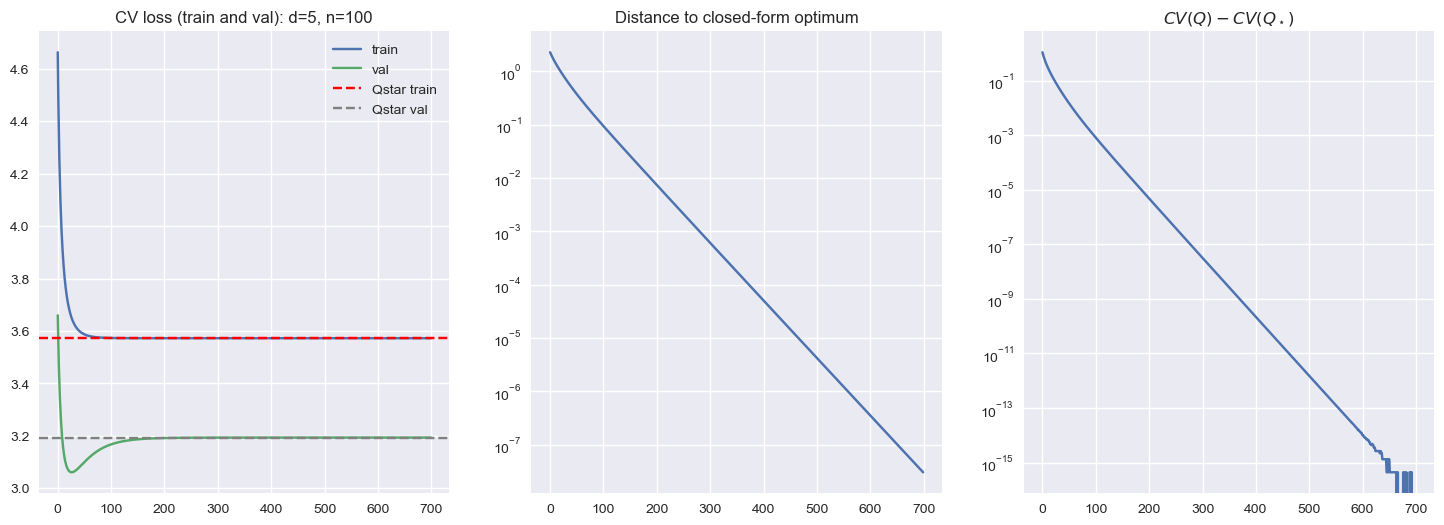

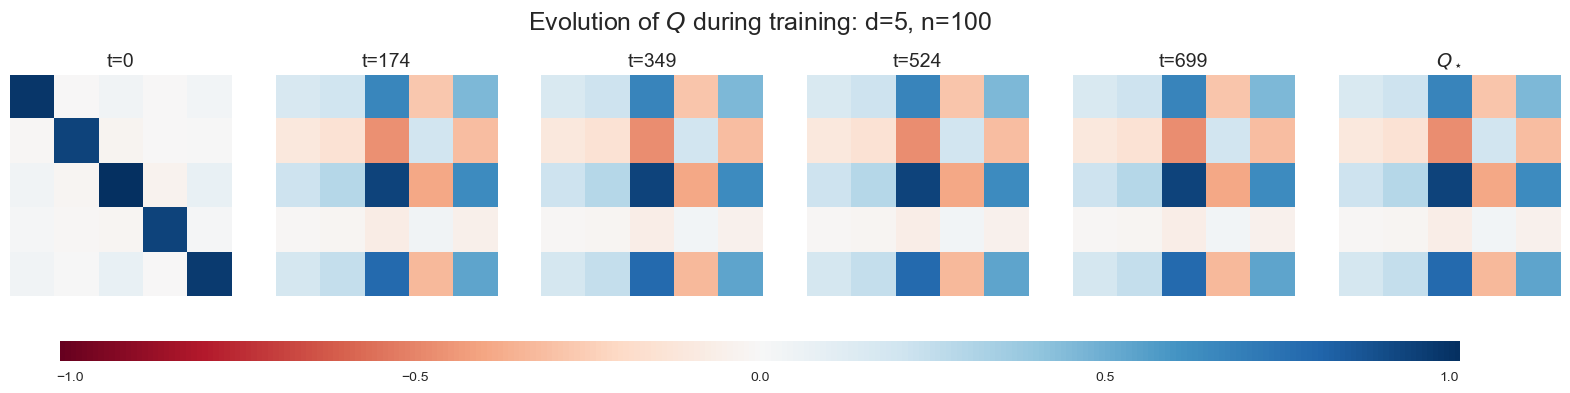

In [60]:
# Training setup
d,n = 5, 100
inner_lr, outer_lr = 0.1, 0.15
n_iters = 700
w_cov = np.eye(d)
w0 = np.ones(d)
Q0 = np.eye(d)

# Training loop
crossvals, Qs, X, y, w_star = potential_training_loop(d, n, inner_lr, outer_lr, w0, Q0, n_iters, w_cov, seed=123)

# --- Plots ---
n_figures = 3
r = range(n_iters)   # range of indices to plot, separated out for easy modification
#r = range(n_iters//2)

# Compute stationarity gaps, crossvals on validation data
X_val = np.random.randn(n, d)
validation_crossvals = np.array([crossval(w0, Q, inner_lr, X_val, X_val @ w_star, ignore_diag=False) for Q in Qs[r]])

# Compute distance to optimum
Qstar = stationary_closed_form(X, w0, w_star, inner_lr)
d_Q_Qstar = np.linalg.norm(Qs - Qstar, axis=(1,2))

plt.figure(figsize=(n_figures * 6, 6))
# Plot crossvals
plt.subplot(1, n_figures, 1)
plt.title(f"CV loss (train and val): d={d}, n={n}")
plt.plot(crossvals[r], label="train")
plt.plot(validation_crossvals[r], label="val")
plt.axhline(crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False), label="Qstar train", linestyle='--', color='red')
plt.axhline(crossval(w0, Qstar, inner_lr, X_val, X_val @ w_star, ignore_diag=False), label="Qstar val", linestyle='--', color='gray')
plt.legend()

# plot distance to optimum
plt.subplot(1, n_figures, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_Q_Qstar[r])
plt.yscale('log')

# diff between CV and "optimal" CV
plt.subplot(1, n_figures, 3)
plt.title("$CV(Q) - CV(Q_\\star)$")
plt.plot(crossvals[r] - crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False))
plt.yscale('log')
plt.show()

plot_matrix_evolution(Qs[r], extra_matrix=Qstar, extra_matrix_title="$Q_\\star$", main_title=f"Evolution of $Q$ during training: d={d}, n={n}")

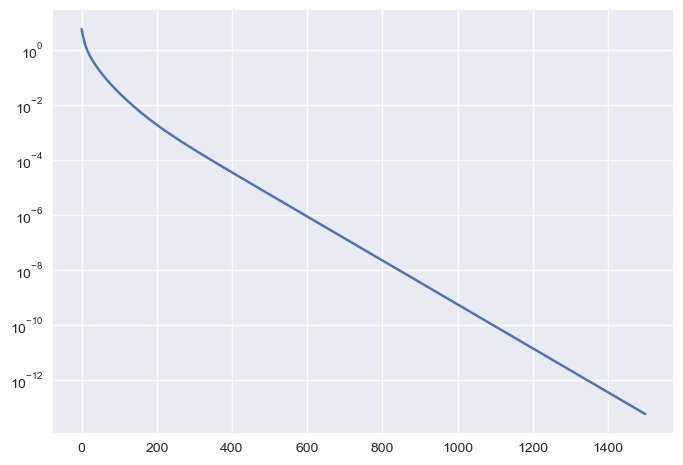

In [84]:
Q_updates = np.array([(Qs[i+1] - Qs[i]) / outer_lr for i in range(len(Qs)-1)])
Q_update_norms = np.linalg.norm(Q_updates, axis=(-1,-2))
plt.plot(Q_update_norms)
plt.yscale('log')
plt.show()

### Compare to a single step of gradient descent

In [61]:
Q_final = Qs[-1]
lr = inner_lr

trained_md_crossvals = []
gd_crossvals = []
X_vals = []
for i in np.arange(1000):
    X_val = np.random.randn(n, d)
    y_val = X_val @ w_star
    trained_md_crossvals.append(crossval(w0, Q_final, lr, X_val, y_val))
    gd_crossvals.append(crossval(w0, np.eye(d), lr, X_val, y_val))
    X_vals.append(X_val)


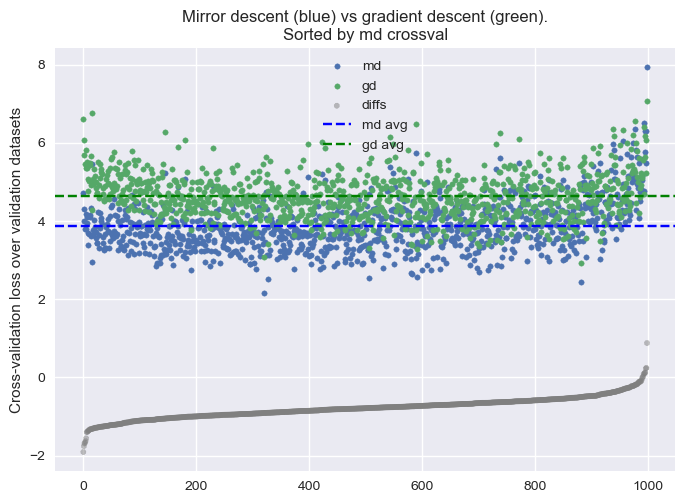

In [62]:
md_gd_crossvals = np.array([trained_md_crossvals, gd_crossvals])
sorted_indices = np.argsort(md_gd_crossvals[0])                        # sort by value of md crossval
sorted_indices = np.argsort(md_gd_crossvals[0] - md_gd_crossvals[1])   # sort by difference between crossvals
md_gd_crossvals = md_gd_crossvals[:, sorted_indices]
X_vals = np.array(X_vals)[sorted_indices]

plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[0], label="md", s=15)
plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[1], label="gd", s=15)
plt.scatter(range(len(md_gd_crossvals[0])), md_gd_crossvals[0] - md_gd_crossvals[1], alpha=0.5, linestyle='--', color='gray', label="diffs", s=15)
plt.axhline(y=np.mean(md_gd_crossvals[0]), label="md avg", color='blue', linestyle='--')
plt.axhline(y=np.mean(md_gd_crossvals[1]), label="gd avg", color='green', linestyle='--')
plt.ylabel("Cross-validation loss over validation datasets")
plt.title("Mirror descent (blue) vs gradient descent (green).\nSorted by md crossval")
plt.legend()
plt.show()

[ 10.  11.  12.  12.  13.  14.  15.  16.  18.  19.  20.  22.  23.  25.
  27.  29.  31.  33.  36.  38.  41.  44.  47.  51.  54.  58.  63.  67.
  72.  77.  83.  89.  95. 102. 110. 118. 126. 136. 146. 156. 168. 180.
 193. 207. 222. 239. 256. 275. 295. 316.]
Finished size n=10
Finished size n=11
Finished size n=12
Finished size n=12
Finished size n=13
Finished size n=14
Finished size n=15
Finished size n=16
Finished size n=18
Finished size n=19
Finished size n=20
Finished size n=22
Finished size n=23
Finished size n=25
Finished size n=27
Finished size n=29
Finished size n=31
Finished size n=33
Finished size n=36
Finished size n=38
Finished size n=41
Finished size n=44
Finished size n=47
Finished size n=51
Finished size n=54
Finished size n=58
Finished size n=63
Finished size n=67
Finished size n=72
Finished size n=77
Finished size n=83
Finished size n=89
Finished size n=95
Finished size n=102
Finished size n=110
Finished size n=118
Finished size n=126
Finished size n=136
Finished size n=14

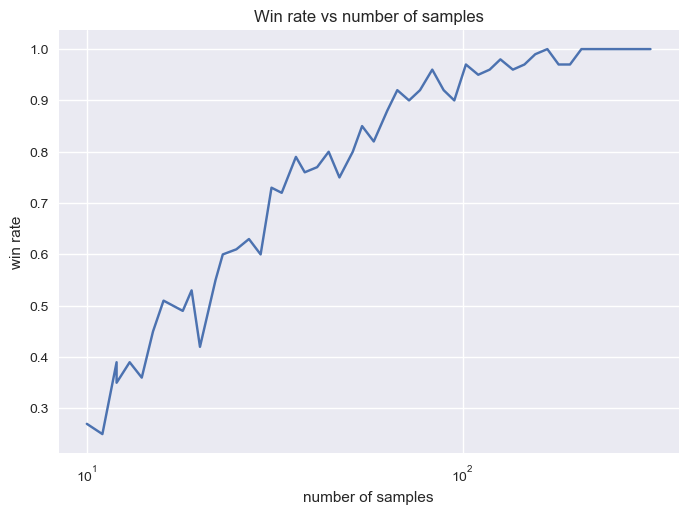

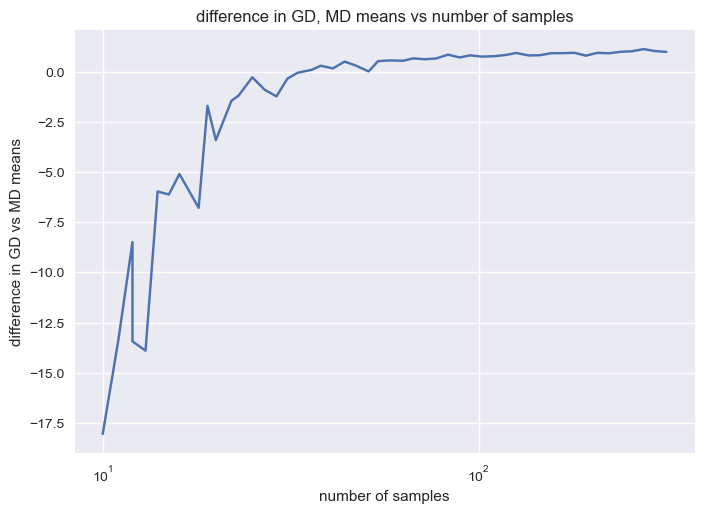

In [63]:
# n vs % of runs that MD wins
d, lr = 5, 0.1
iters_per_size = 100
w0 = np.ones(d)

win_counts = []
mean_diffs = []

sizes = np.round(np.logspace(1, 2.5, 50))
print(sizes)
for n in sizes:
    n = int(n)
    qstar_crossvals = []
    gd_crossvals = []

    for i in np.arange(iters_per_size):
        X, y, w_star = generate_linear_data(d, n)
        Qstar = stationary_closed_form(X, w0, w_star, inner_lr)

        X_val = np.random.randn(n, d)
        y_val = X_val @ w_star
        qstar_crossvals.append(crossval(w0, Qstar, lr, X_val, y_val))
        gd_crossvals.append(crossval(w0, np.eye(d), lr, X_val, y_val))

    md_gd_crossvals = np.array([qstar_crossvals, gd_crossvals])
    win_counts.append(np.mean(md_gd_crossvals[0] < md_gd_crossvals[1]))
    mean_diffs.append(np.mean(md_gd_crossvals[1] - md_gd_crossvals[0]))
    print(f"Finished size n={n}")

plt.plot(sizes, win_counts)
plt.xscale('log')
plt.xlabel("number of samples")
plt.ylabel("win rate")
plt.title("Win rate vs number of samples")
plt.show()

plt.plot(sizes, mean_diffs)
plt.xscale('log')
plt.xlabel("number of samples")
plt.ylabel("difference in GD vs MD means")
plt.title("difference in GD, MD means vs number of samples")
plt.show()


## Graphs for mixed $w$ / recovering covariance

Questions:
* Are there consistent, visible patterns in $Q$?
* What properties are preseved between multiple runs with different data?
* How does $\Sigma_w$ itself perform as a mirror map?

### Generic "run experiment" function

In [64]:
def potential_training_loop_mixed_w(d, n_samples_per_w, n_ws, inner_lr, outer_lr, w0, Q0, n_iters,
                                    w_cov=None, noise_scale=0.):
    
    X, y, W_stars = generate_mixed_linear_data(d, n_samples_per_w, n_ws, w_cov, noise_scale)

    Q = Q0.copy()
    crossvals = np.zeros(n_iters)
    Qs = np.zeros((n_iters, d, d))
    for i in range(n_iters):
        Qs[i] = Q.copy()
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=True)
        Q = potential_update(w0, Q, outer_lr, inner_lr, X, y, ignore_diag=False)

    return crossvals, Qs, X, y, W_stars

### Low-rank $\Sigma_w$

<>:18: SyntaxWarning: invalid escape sequence '\S'
<>:18: SyntaxWarning: invalid escape sequence '\S'
/var/folders/g5/npqksqc90_34xrpm8z4vpprr0000gn/T/ipykernel_46023/1996814531.py:18: SyntaxWarning: invalid escape sequence '\S'
  plt.title(f"CV loss: d={d}, n={nspw * n_ws}, rank($\Sigma_w$)={rank}")


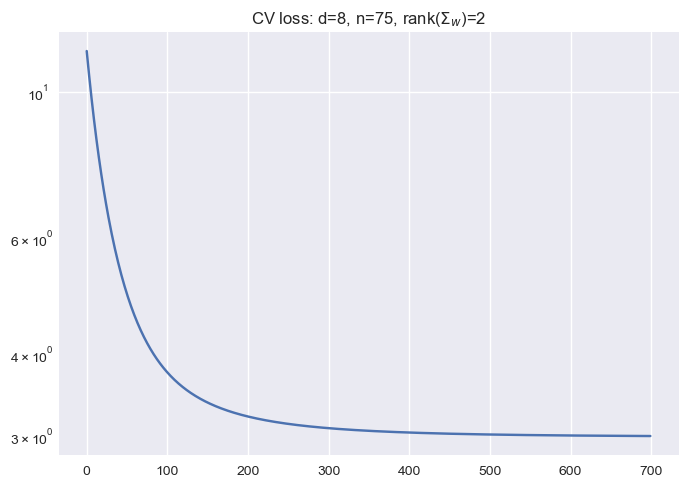

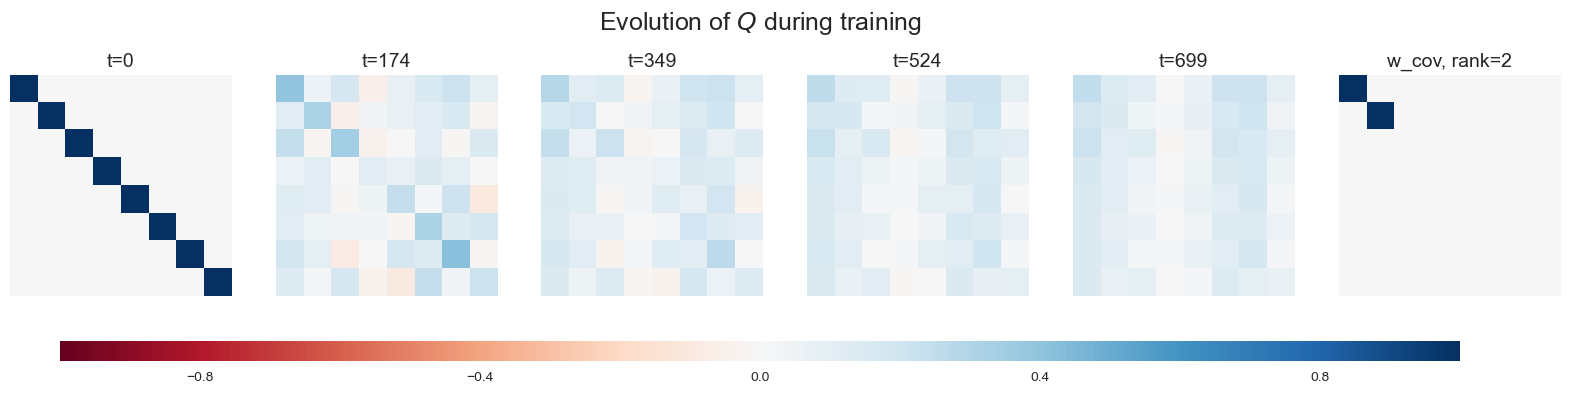

In [65]:
# other parameters for training
d, nspw, n_ws = 8, 3, 25  # nspw = n_samples_per_w
inner_lr, outer_lr = 0.3, 0.005
n_iters = 700
w0 = np.ones(d)
Q0 = np.eye(d)

# setting up w_cov
rank = 2
assert rank < d, f"rank {rank} should be less than dimension {d}"
w_cov = np.diag([1]*rank + [0]*(d-rank))

# Train potential
crossvals, Qs, X, y, W_stars = potential_training_loop_mixed_w(d, nspw, n_ws, inner_lr, outer_lr, w0, Q0, n_iters, w_cov)

# Plot crossvals
plt.plot(crossvals)
plt.title(f"CV loss: d={d}, n={nspw * n_ws}, rank($\Sigma_w$)={rank}")
plt.yscale('log')

# Plot images of Q iterates over time
plot_matrix_evolution(Qs, extra_matrix=w_cov, extra_matrix_title=f'w_cov, rank={rank}', main_title='Evolution of $Q$ during training')

### Poorly-conditioned $\Sigma_w$

## Stationary-Point Conditions

### $L_{ij}$ stationary point condition: $x_j^\top Q x_i = z_j / (2 \eta z_i)$

In [66]:
# X_val = np.random.randn(n, d)

# sp_diffs = np.array([stationarity_condition_Q_Lij(Q, X, w0, w_star, lr) for Q in Qs])
# sp_diffs_val = np.array([stationarity_condition_Q_Lij(Q, X_val, w0, w_star, lr) for Q in Qs])

# mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
# max_abs_diffs = np.max(np.abs(sp_diffs), axis=(1,2))
# min_abs_diffs = np.min(np.abs(sp_diffs), axis=(1,2))

# mean_abs_diffs_val = np.mean(np.abs(sp_diffs_val), axis=(1,2))
# max_abs_diffs_val= np.max(np.abs(sp_diffs_val), axis=(1,2))
# min_abs_diffs_val= np.min(np.abs(sp_diffs_val), axis=(1,2))

# #plt.plot(max_abs_diffs)
# plt.plot(mean_abs_diffs, label="train")
# plt.plot(mean_abs_diffs_val, label="val")
# plt.legend()
# #plt.plot(min_abs_diffs)
# plt.yscale('log')
# plt.show()


### Full-energy stationary-point condition

$$2\eta \sum_{i,j} \varepsilon_j (x_i^\top Q x_j) x_{ik}x_{j\ell}  = \sum_{i,j} \varepsilon_i \varepsilon_j x_{ik} x_{j\ell}.$$

In [67]:
# X_val = np.random.randn(n, d)
# lr = inner_lr

# sp_diffs = np.array([stationarity_condition_Q_full(Q, X, w0, w_star, lr) for Q in Qs])
# sp_diffs_val = np.array([stationarity_condition_Q_full(Q, X_val, w0, w_star, lr) for Q in Qs])

# mean_abs_diffs = np.mean(np.abs(sp_diffs), axis=(1,2))
# max_abs_diffs = np.max(np.abs(sp_diffs), axis=(1,2))
# min_abs_diffs = np.min(np.abs(sp_diffs), axis=(1,2))

# mean_abs_diffs_val = np.mean(np.abs(sp_diffs_val), axis=(1,2))
# max_abs_diffs_val= np.max(np.abs(sp_diffs_val), axis=(1,2))
# min_abs_diffs_val= np.min(np.abs(sp_diffs_val), axis=(1,2))

# #plt.plot(max_abs_diffs)
# plt.plot(mean_abs_diffs, label="train")
# plt.plot(mean_abs_diffs_val, label="val")
# plt.legend()
# #plt.plot(min_abs_diffs)
# plt.yscale('log')
# plt.show()

# $UU^\top$ parameterization

## Basic training loop

In [68]:
def mirror_descent_step_U(w: np.ndarray, U: np.ndarray, lr: float, x: np.ndarray, y: float) -> np.ndarray:
    """
    Single step of mirror descent.
    Just calls `mirror_descent_step` with `Q = U @ U.T`.

    [ 7.1: this function isn't actually used right now, since the potential update computes this manually ]

    Args:
        w: Current weight vector (d_feature, 1).
        U: Factor of potential matrix: Q = U @ U.T
        lr: Learning rate.
        x: Feature vector (d_feature,).
        y: Target value.

    Returns:
        Updated weight vector (d_feature,).
    """
    return mirror_descent_step(w, U @ U.T, lr, x, y)


def crossval_U(w: np.ndarray, U: np.ndarray, lr: float, X: np.ndarray, y: np.ndarray,
             ignore_diag=True) -> float:
    """
    Perform leave-one-out cross-validation.
    Just calls `crossval` with `Q = U @ U.T`.

    For each (x_i, y_i) in the dataset:
    1. "Train" a model with a single step of mirror descent on (x_i, y_i)
    2. Evaluate it on the rest of the dataset

    Tested against non-vectorized version, performs identically.

    Args:
        w: Initial weight vector (d_feature,).
        U: Factor of potential matrix: Q = U @ U.T
        lr: Learning rate.
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).

    Returns:
        Average loss over all i, j with i != j.
    """
    return crossval(w, U @ U.T, lr, X, y, ignore_diag)

def potential_update_U(w: np.ndarray, U: np.ndarray, outer_lr: float, inner_lr: float, X: np.ndarray, y: np.ndarray,
                       ignore_diag=True) -> np.ndarray:
    """
    Update the potential matrix U based on the derivative of the cross-validation loss, where Q = UU^T.

    Args:
        w: Current weight vector (d_feature,).
        U: Current potential matrix factor (d_feature, d_feature).
        outer_lr: Learning rate for updating U.
        inner_lr: Learning rate for the inner mirror descent step (η in the formula).
        X: Feature matrix (n_samples, d_feature).
        y: Target vector (n_samples,).
        ignore_diag: Whether to ignore diagonal terms in the loss calculation.

    Returns:
        Updated potential matrix factor U (d_feature, d_feature).
    """
    n_samples = X.shape[0]
    denom = n_samples ** 2
    
    errors = X @ w - y
    L = errors - 2 * inner_lr * errors[:, np.newaxis] * X @ U @ U.T @ X.T
    
    if ignore_diag:
        np.fill_diagonal(L, 0)
        denom -= n_samples

    L_errors = L * errors[:, np.newaxis]  # (n_samples, n_samples)
    update = X.T @ (L_errors + L_errors.T) @ X @ U
    
    # Apply scaling factor
    update *= -2 * inner_lr / denom
    assert update.shape == U.shape, f"Potential update of shape {update.shape} is incompatible with U shape of {U.shape}."
    
    # Update U using gradient descent
    return U - outer_lr * update

In [133]:
def potential_training_loop_U(d, n, inner_lr, outer_lr, w0, U0, n_iters,
                            w_cov=None, noise_scale=0., seed=None):
    """
    Basic training loop.
    Generates linear data and runs potential_update for n_iters iterations.

    Returns crossvals, Qs, X, y, w_star.
    """
    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)

    Us = [U0]
    crossvals = [crossval_U(w0, U0, inner_lr, X, y, ignore_diag=False)]
    U = U0.copy()
    for i in range(n_iters):
        U = potential_update_U(w0, U, outer_lr, inner_lr, X, y, ignore_diag=False)
        Us.append(U)
        crossvals.append(crossval_U(w0, U, inner_lr, X, y, ignore_diag=False))

    Us = np.array(Us)
    crossvals = np.array(crossvals)

    return crossvals, Us, X, y, w_star

### Claude's numerical correctness check for `potential_update_U` 
## **TODO: VERIFY THAT THIS MAKES SENSE**

In [154]:
from scipy.linalg import eigvalsh

def numerical_gradient(w, U, inner_lr, X, y, epsilon=1e-8):
    """Compute numerical gradient of CV loss with respect to U."""
    grad = np.zeros_like(U)
    for i in range(U.shape[0]):
        for j in range(U.shape[1]):
            U_plus = U.copy()
            U_plus[i, j] += epsilon
            U_minus = U.copy()
            U_minus[i, j] -= epsilon
            grad[i, j] = (crossval_U(w, U_plus, inner_lr, X, y) - 
                          crossval_U(w, U_minus, inner_lr, X, y)) / (2 * epsilon)
    return grad


def test_potential_update_U():
    # Generate random data
    n_samples, d_feature = 20, 5
    X = np.random.randn(n_samples, d_feature)
    w = np.random.randn(d_feature)
    y = X @ w + np.random.randn(n_samples) * 0.1
    U = np.random.randn(d_feature, d_feature)
    
    # Set learning rates
    outer_lr, inner_lr = 0.01, 0.1
    
    # Compute update using our function
    U_new = potential_update_U(w, U, outer_lr, inner_lr, X, y)
    actual_update = (U_new - U) / outer_lr
    
    # Compute numerical gradient
    numerical_grad = numerical_gradient(w, U, inner_lr, X, y)
    
    # Compare the results
    assert_allclose(actual_update, -numerical_grad, rtol=1e-4, atol=1e-4,
                    err_msg="Gradient from potential_update_U doesn't match numerical gradient")
    
    # Check if the resulting Q is positive semidefinite
    Q_new = U_new @ U_new.T
    min_eigenvalue = eigvalsh(Q_new).min()
    assert min_eigenvalue >= -1e-10, f"Resulting Q is not positive semidefinite. Min eigenvalue: {min_eigenvalue}"
    
    print("All tests passed!")

# Run the test
test_potential_update_U()

AssertionError: 
Not equal to tolerance rtol=0.0001, atol=0.0001
Gradient from potential_update_U doesn't match numerical gradient
Mismatched elements: 25 / 25 (100%)
Max absolute difference: 0.09099027
Max relative difference: 1.54206703
 x: array([[ 0.001224, -0.000498, -0.000355, -0.00196 , -0.00082 ],
       [ 0.003912, -0.006819,  0.006073, -0.007631, -0.005594],
       [-0.031985,  0.021323, -0.018712,  0.051392,  0.022868],...
 y: array([[0.059005, 0.059005, 0.059005, 0.059005, 0.059005],
       [0.059005, 0.059005, 0.059005, 0.059005, 0.059005],
       [0.059005, 0.059005, 0.059005, 0.059005, 0.059005],...

## Stationarity condition on full loss ❌ (not working yet)

In [193]:
def stationarity_condition_U_loop(U, X, w, w_star, lr):
    n = X.shape[0]
    errors = X @ (w - w_star)
    cond = 0
    for i in range(n):
        for j in range(n):
            cond += errors[j] * (errors[i] - 2 * lr * errors[j] * np.outer(U @ X[i], U @ X[j])) * (np.outer(X[i], X[j]) + np.outer(X[j], X[i]))
    return cond @ U


def stat_condition_1(U, X, w, w_star, lr):
    """explicitly writing out loop"""
    n = X.shape[0]
    errors = X @ (w - w_star)
    lhs = 0
    rhs = 0
    for i in range(n):
        for j in range(n):
            lhs += errors[i] * errors[j]
            rhs += np.inner(U.T @ X[i], U.T @ X[j]) * errors[j]**2
    rhs *= 2 * lr
    return lhs, rhs

def stat_condition_2(U, X, w, w_star, lr):
    """tested: lhs, rhs identical to 1"""
    errors = X @ (w - w_star)
    lhs = np.sum(np.outer(errors, errors))
    rhs = 2 * lr * np.sum(X @ U @ U.T @ X.T @ (errors ** 2))
    return lhs, rhs


def stationarity_condition_U_full(U, X, w, w_star, lr, return_pair=False):
    errors = X @ (w - w_star)  # (n,)
    E2 = np.diag(errors)**2  # (n, n)
    XTe = X.T @ errors  # (d,)

    lhs = np.outer(XTe, XTe) @ U # (d,d)
    rhs = lr * X.T @ X @ U @ U.T @ X.T @ E2 @ X @ U  # (d,d)
    if return_pair:
        return lhs, rhs
    return lhs - rhs

def stationarity_condition_UUT_full(UUT, X, w, w_star, lr, return_pair=False):
    errors = X @ (w - w_star)  # (n,)
    E2 = np.diag(errors)**2  # (n, n)
    XTe = X.T @ errors  # (d,)

    lhs = np.outer(XTe, XTe) # (d,d)
    rhs = lr * X.T @ X @ UUT @ X.T @ E2 @ X  # (d,d)
    if return_pair:
        return lhs, rhs
    return lhs - rhs 

def stationary_closed_form_UUT(X, w, w_star, lr):
    """
    Returns the matrix Q = UU^T that falls out of solving dCV/dU = 0.
    Assumptions: U, X^T E X, and X^T X are invertible.
    """
    z = w - w_star
    E2 = np.diag(X @ z)**2   # E squared
    return np.outer(z, z) @ X.T @ X @ np.linalg.inv(X.T @ E2 @ X) / lr

# def stationary_closed_form_UUT_deprecated(X, w, w_star, lr):
#     """
#     Returns the matrix Q = UU^T that falls out of solving dCV/dU = 0.
#     Assumptions: no zero entries in U, and (X^T (E^2 + I) X) is invertible.
#     """
#     z = w - w_star
#     E2 = np.diag(X @ z)**2   # E squared
#     xTeixinv = np.linalg.inv((X.T @ (E2 + np.eye(X.shape[0])) @ X)) # (X.T (E2 + I) X)^{-1}
#     xTx = X.T @ X
#     return xTeixinv @ xTx @ np.outer(z, z) @ xTx @ xTeixinv / lr

In [192]:
d, n, lr = 5, 10, 0.1
X, y, w_star = generate_linear_data(d, n)
w0 = np.ones((d,))
U = np.random.randn(d,d)
l1 = stationarity_condition_U_loop(U, X, w0, w_star, lr)
l2= stationarity_condition_U_full(U, X, w0, w_star, lr)
#loop = stationarity_condition_U_loop(U, X, w0, w_star, lr)
assert_allclose(l1, l2)
# assert_allclose(r1, r2)


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 25 / 25 (100%)
Max absolute difference: 6049.24156434
Max relative difference: 4.88961024
 x: array([[ -796.456389, -1845.831086,  1383.526765, -1207.272957,
         1049.746681],
       [  210.162232,    46.173404,   586.893547,   422.09176 ,...
 y: array([[  204.765089,   718.846738,  -482.342037,   686.863215,
         -713.637126],
       [ -581.89909 , -1620.309711,  1131.325746, -1162.698694,...

In [194]:
def test_stationary_closed_form_U():
    d, n, lr = 5, 10, 0.1
    X, y, w_star = generate_linear_data(d, n)
    w0 = np.ones((d,))
    UUT_star = stationary_closed_form_UUT(X, w0, w_star, lr)
    lhs, rhs = stationarity_condition_U_full(UUT_star, X, w0, w_star, lr, return_pair=True)
    try:
        assert_allclose(lhs, rhs, )
    except AssertionError as e:
        print("assert_allclose failed: Closed-form matrix isn't passing stationary condition.")
        print(e) 

test_stationary_closed_form_U()

assert_allclose failed: Closed-form matrix isn't passing stationary condition.

Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 25 / 25 (100%)
Max absolute difference: 209895.74631415
Max relative difference: 1.08760869
 x: array([[ 885.06614 , -190.068132, -424.178685,  756.085753,   48.137301],
       [-190.068132,   40.817169,   91.092458, -162.369567,  -10.337495],
       [-424.178685,   91.092458,  203.29278 , -362.363269,  -23.070385],...
 y: array([[ -10102.492838,   67356.585054,    6591.576249,  210651.832067,
         -38001.021087],
       [   2169.512368,  -14464.840182,   -1415.542325,  -45237.523286,...


## Graphs for single $w$

In [148]:
# Training setup
d,n = 5, 100
inner_lr, outer_lr = 0.1, 0.1
n_iters = 1000
w_cov = np.eye(d)
w0 = np.ones(d)
U0 = np.eye(d)

# Training loop
crossvals, Us, X, y, w_star = potential_training_loop_U(d, n, inner_lr, outer_lr, w0, U0, n_iters, w_cov)

UUTstar = stationary_closed_form_UUT(X, w0, w_star, inner_lr)
UUTs = np.array([U @ U.T for U in Us])

# Compute distance to optimum
d_UUT_UUTstar = np.linalg.norm(UUTs - UUTstar, axis=(1,2))
r = range(n_iters)

# Plot crossvals
plt.figure(figsize=(24, 5))
plt.subplot(1, 3, 1)
plt.title(f"CV loss: d={d}, n={n}")
plt.plot(crossvals[r], label="train")
plt.axhline(crossval(w0, UUTstar, inner_lr, X, y, ignore_diag=False), label="Qstar train", linestyle='--', color='red')

# plot distance to optimum
plt.subplot(1, 3, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_UUT_UUTstar[r])
plt.yscale('log')

# diff between CV and "optimal" CV
plt.subplot(1, 3, 3)
plt.title("$CV(Q) - CV(Q_\\text{last})$ (first 90%)")
plt.plot((crossvals[r] - crossval(w0, UUTs[-1], inner_lr, X, y, ignore_diag=False))[:-n_iters//10])
plt.yscale('log')
plt.show()

plot_matrix_evolution(Us, main_title=f"Evolution of $U$ during training: d={d}, n={n}")
scale = np.linalg.norm(UUTs[-1]) / np.linalg.norm(UUTstar)
plot_matrix_evolution(UUTs, main_title=f"Evolution of $UU^\\top$ during training: d={d}, n={n}", extra_matrix=scale * UUTstar, extra_matrix_title=f"scaled $Q_\\star$")

NameError: name 'stationary_closed_form_UUT' is not defined

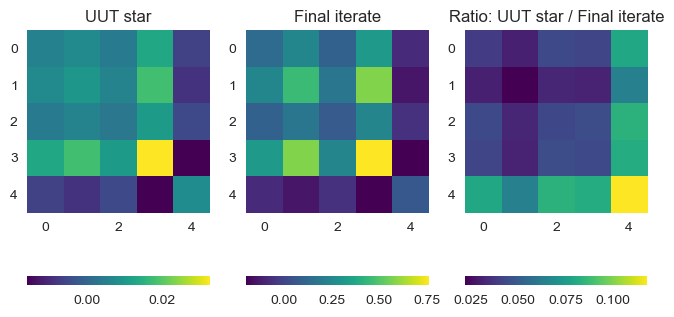

In [146]:
plt.figure()

plt.subplot(1, 3, 1)

plt.imshow(UUTstar, cmap='viridis')
plt.colorbar(orientation='horizontal')
plt.title("UUT star")
plt.grid(0)

plt.subplot(1, 3, 2)
plt.imshow(UUTs[-1], cmap='viridis')
plt.colorbar(orientation='horizontal')
plt.grid(0)
plt.title("Final iterate")

plt.subplot(1, 3, 3)
plt.imshow(UUTstar / UUTs[-1], cmap='viridis')
plt.colorbar(orientation='horizontal')
plt.grid(0)
plt.title("Ratio: UUT star / Final iterate")

plt.show()

## Graphs for mixed $w$ / recovering covariance

# ANNEX. Code that's likely temporary, and I don't want it to be in the way anywhere else. Proceed with caution.

training complete
aux values computed


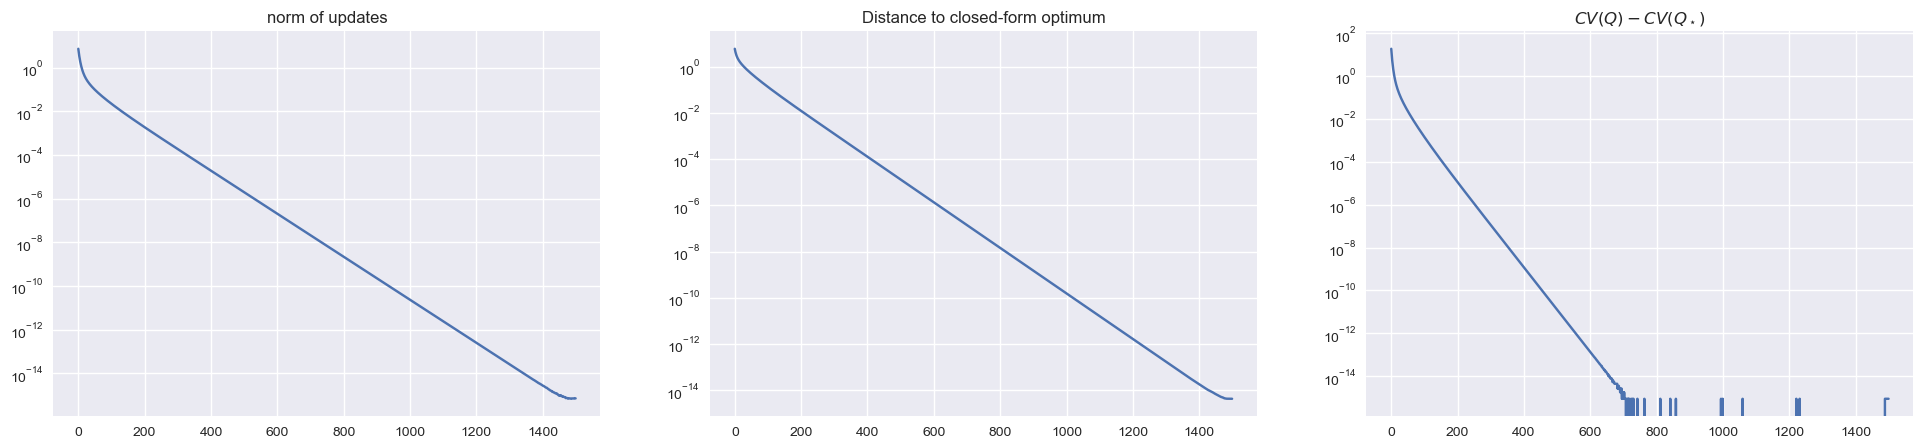

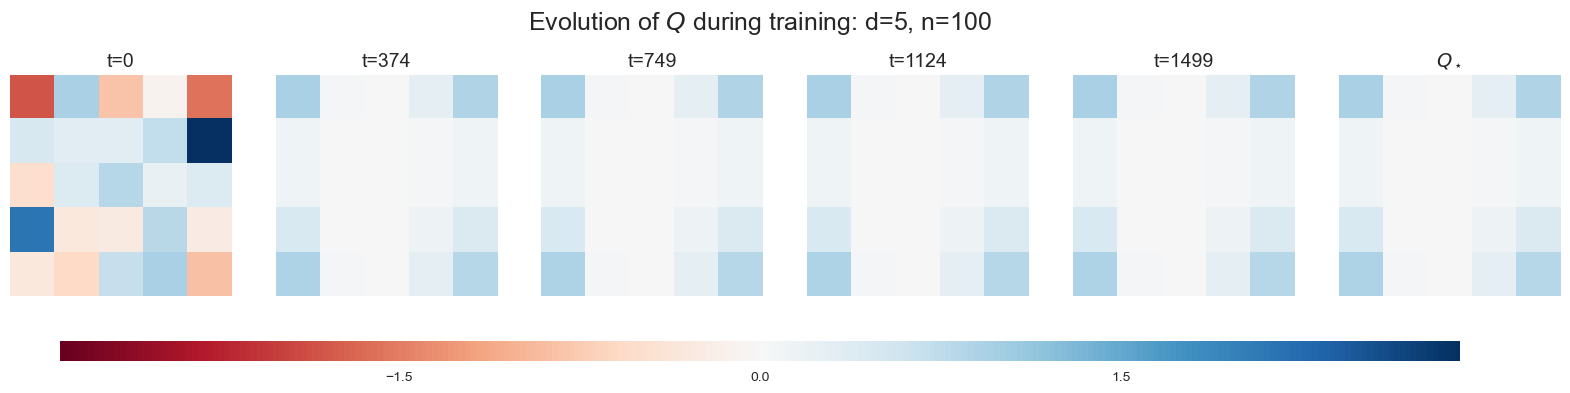

In [77]:
def train_potential_return_updates(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                            w_cov=None, noise_scale=0., seed=None, ignore_diag=False):
    """
    Basic training loop.
    Generates linear data and runs potential_update for n_iters iterations.

    Returns crossvals, Qs, X, y, w_star.

    **TODO: not sure "seed" works the way I want here to give reproducibility?
    """
    if seed:
        np.random.seed = seed

    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)

    crossvals = np.zeros(n_iters)
    Q = Q0.copy()
    Qs = [Q0.copy()]
    updates = []
    for i in range(n_iters):
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=False)

        errors = X @ w0 - y
        XQX = X @ Q.T @ X.T
        L = errors - 2 * inner_lr * errors[:, np.newaxis] * XQX
        
        if ignore_diag:
            np.fill_diagonal(L, 0)
            denom = n * (n- 1)
        else:
            denom = n ** 2
        
        # Corrected matrix operations to match the original einsum
        L_errors = L.T * errors  # (n_samples, n_samples)
        update = X.T @ L_errors @ X  # (d_feature, d_feature)
        update *= -2 * inner_lr / denom

        Q -= outer_lr * update
        updates.append(update.copy())
        Qs.append(Q.copy())

    updates = np.array(updates)
    Qs = np.array(Qs)
    return crossvals, Qs, updates, X, y, w_star


# Training setup
d,n = 5, 100
inner_lr, outer_lr = 0.1, 0.15
n_iters = 1500
w_cov = np.eye(d)
w0 = np.ones(d)
#Q0 = np.eye(d)
Q0 = np.random.randn(d,d)

# Training loop
crossvals, Qs, updates, X, y, w_star = train_potential_return_updates(d, n, inner_lr, outer_lr, w0, Q0, n_iters, w_cov, seed=123)
print("training complete")

# --- Plots ---
n_figures = 3
r = range(n_iters)   # range of indices to plot, separated out for easy modification
#r = range(n_iters//2)

X_val = np.random.randn(n, d)

# Compute distance to optimum
Qstar = stationary_closed_form(X, w0, w_star, inner_lr)
d_Q_Qstar = np.linalg.norm(Qs - Qstar, axis=(1,2))
print("aux values computed")


plt.figure(figsize=(24, 5))
# Plot crossvals
plt.subplot(1, n_figures, 1)
plt.title("norm of updates")
plt.plot([np.linalg.norm(update) for update in updates])
plt.yscale('log')


# plot distance to optimum
plt.subplot(1, n_figures, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_Q_Qstar[r])
plt.yscale('log')

# diff between CV and "optimal" CV
plt.subplot(1, n_figures, 3)
plt.title("$CV(Q) - CV(Q_\\star)$")
plt.plot(crossvals[r] - crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False))
plt.yscale('log')
plt.show()

plot_matrix_evolution(Qs[r], extra_matrix=Qstar, extra_matrix_title="$Q_\\star$", main_title=f"Evolution of $Q$ during training: d={d}, n={n}")

training complete
aux values computed


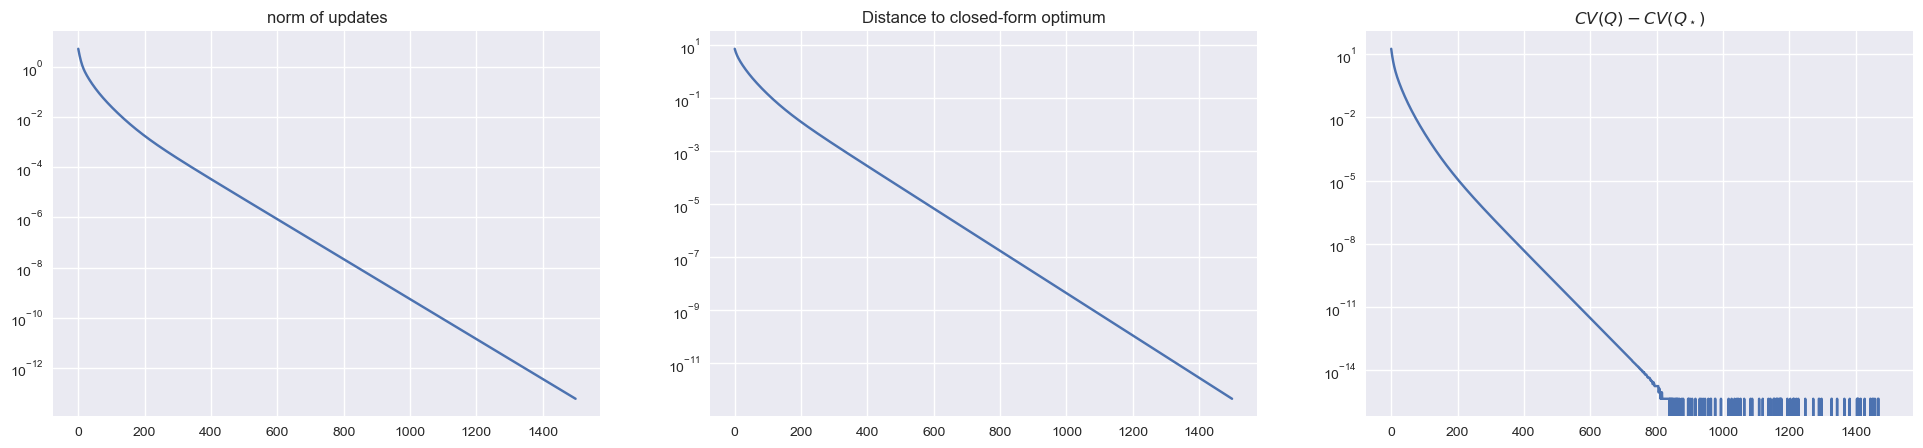

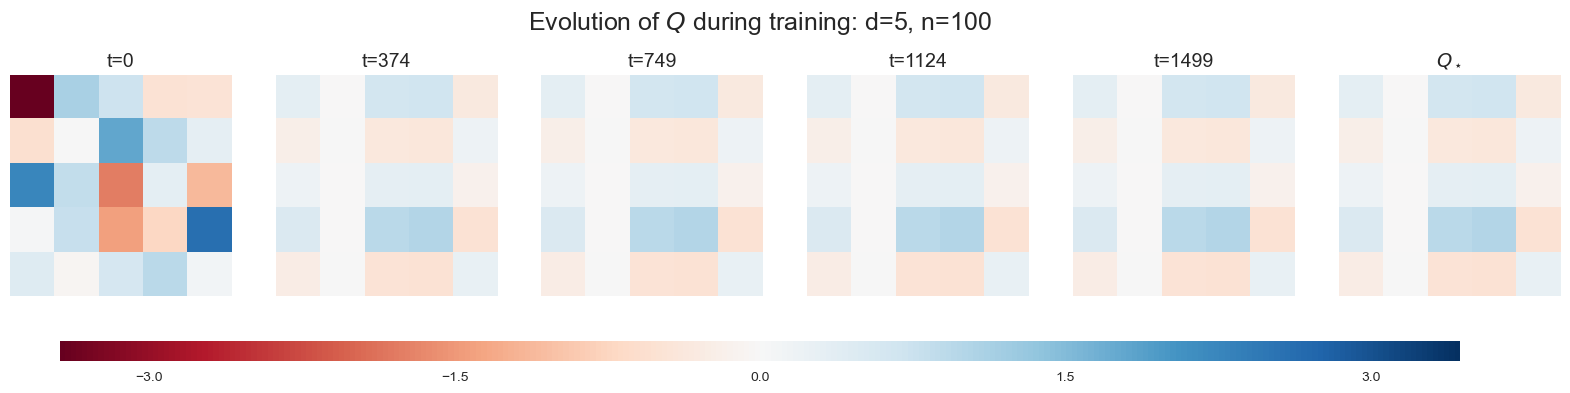

In [78]:
def train_potential_return_updates(d, n, inner_lr, outer_lr, w0, Q0, n_iters,
                            w_cov=None, noise_scale=0., seed=None, ignore_diag=False):
    """
    Basic training loop.
    Generates linear data and runs potential_update for n_iters iterations.

    Returns crossvals, Qs, X, y, w_star.

    **TODO: not sure "seed" works the way I want here to give reproducibility?
    """
    if seed:
        np.random.seed = seed

    X, y, w_star = generate_linear_data(d, n, w_cov, noise_scale)

    crossvals = np.zeros(n_iters)
    Q = Q0.copy()
    Qs = [Q0.copy()]
    updates = []
    for i in range(n_iters):
        crossvals[i] = crossval(w0, Q, inner_lr, X, y, ignore_diag=False)

        errors = X @ w0 - y
        XQX = X @ Q.T @ X.T
        L = errors - 2 * inner_lr * errors[:, np.newaxis] * XQX
        
        if ignore_diag:
            np.fill_diagonal(L, 0)
            denom = n * (n- 1)
        else:
            denom = n ** 2
        
        # Corrected matrix operations to match the original einsum
        L_errors = L.T * errors  # (n_samples, n_samples)
        update = X.T @ L_errors @ X  # (d_feature, d_feature)
        update *= -2 * inner_lr / denom

        Q -= outer_lr * update
        updates.append(update.copy())
        Qs.append(Q.copy())

    updates = np.array(updates)
    Qs = np.array(Qs)
    return crossvals, Qs, updates, X, y, w_star


# Training setup
d,n = 5, 100
inner_lr, outer_lr = 0.1, 0.15
n_iters = 1500
w_cov = np.eye(d)
w0 = np.ones(d)
#Q0 = np.eye(d)
Q0 = np.random.randn(d,d)

# Training loop
crossvals, Qs, updates, X, y, w_star = train_potential_return_updates(d, n, inner_lr, outer_lr, w0, Q0, n_iters, w_cov, seed=123)
print("training complete")

# --- Plots ---
n_figures = 3
r = range(n_iters)   # range of indices to plot, separated out for easy modification
#r = range(n_iters//2)

X_val = np.random.randn(n, d)

# Compute distance to optimum
Qstar = stationary_closed_form(X, w0, w_star, inner_lr)
d_Q_Qstar = np.linalg.norm(Qs - Qstar, axis=(1,2))
print("aux values computed")


plt.figure(figsize=(24, 5))
# Plot crossvals
plt.subplot(1, n_figures, 1)
plt.title("norm of updates")
plt.plot([np.linalg.norm(update) for update in updates])
plt.yscale('log')


# plot distance to optimum
plt.subplot(1, n_figures, 2)
plt.title("Distance to closed-form optimum")
plt.plot(d_Q_Qstar[r])
plt.yscale('log')

# diff between CV and "optimal" CV
plt.subplot(1, n_figures, 3)
plt.title("$CV(Q) - CV(Q_\\star)$")
plt.plot(crossvals[r] - crossval(w0, Qstar, inner_lr, X, y, ignore_diag=False))
plt.yscale('log')
plt.show()

plot_matrix_evolution(Qs[r], extra_matrix=Qstar, extra_matrix_title="$Q_\\star$", main_title=f"Evolution of $Q$ during training: d={d}, n={n}")

# final cell

In [79]:
print(f"Time elapsed: {perf_counter() - NOTEBOOK_START_TIME:.2f} seconds")

Time elapsed: 3365.94 seconds
